# Parte 4: Clasificación con CNN

### Resultados con la arquitectura anterior: 

Resultados:
    
    TRAIN                   DEV
    loss       accuracy     val_loss    val_accuracy
    0.257217	0.894231	0.472333	0.692308
    
Por tanto: 

    E = 1 - Accuracy
    Etrain = 1 - 0.894231 = 0.105769
    Etest = 1 - 0.692308 = 0.307692
    
    Bias = Etrain - Ehuman = 0.105769
    Variance = Etest - Etrain = 0.307692 - 0.105769 = 0.201923

El bias ha aumentado, y aunque la varianza es alta habrá que que seguir tratando de bajar el bias. Para mejorar esto será necesario añadir más complejidad, elegir una mejor optimización, cambiando la arquitectura (más neuronas, más capas)...

### Cambios realizados

La capa de 40 unidades (filtros) pasa a tener 50 para añadir más neuronas. Se añade una segunda capa de 50 unidades duplicando a la anterior añadida. 

### Nuevos resultados: 

Resultados:
    
    TRAIN                   DEV
    loss       accuracy     val_loss    val_accuracy
    
    0.181817	0.913462	0.642329	0.576923
    
Por tanto: 

    E = 1 - Accuracy
    Etrain = 1 - 0.913462 = 0.086538
    Etest = 1 - 0.576923 = 0.423077
    
    Bias = Etrain - Ehuman = 0.086538
    Variance = Etest - Etrain = 0.423077 - 0.086538 = 0.336539

El bias se ha reducido, pero la varianza es muy alta. Es el momento de tratar la varianza.  Para ello habrá que o regularizar, o cambiar la arquitectura (menos neuronas => Mejor varianza, más capas => mayor abstracción), o añadir más datos (cosa que no es posible).

### 1 - Import Libraries

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Signal libraries
from scipy import signal


### 2 - Load data

In [2]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [3]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    mdata = mat['session']
    val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(val["task_EEG_p"]), np.array(val["data_processed_EEG"]))
    return output

### Cargamos los datos

In [4]:
# Configuración
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron
from keras.utils import to_categorical


task1 = 402 # SE PUEDE CAMBIAR
task2 = 404 # SE PUEDE CAMBIAR
task_OneHotEnconding = {402: [1.,0.], 404: [0.,1.]}
user = 'W29' # SE PUEDE CAMBIAR
day = '0329'
folder_day = 'W29-29_03_2021'
total_records = 22 # CAMBIAR SI HAY MAS REGISTROS
fm = 200
electrodes_names_selected = ['F3', 'FZ', 'FC1','FCZ','C1','CZ','CP1','CPZ', 'FC5', 'FC3','C5','C3','CP5','CP3','P3',
                             'PZ','F4','FC2','FC4','FC6','C2','C4','CP2','CP4','C6','CP6','P4','HR' ,'HL', 'VU', 'VD']
number_channels = len(electrodes_names_selected)

In [5]:
lTaskData = []
total_records_used = 0
for i_rec in range(1,total_records+1):
    i_rec_record = i_rec
    if i_rec_record <10:
        i_rec_record = "0"+str(i_rec_record)
    if i_rec % 2 == 0: # Registros impares primero: USUARIO SIN MOVIMIENTO SOLO PENSANDO
        record = "./RegistrosProcesados2/"+folder_day+"/W29_2021"+day+"_openloop_"+str(i_rec_record)+"_processed.mat"
        output = read_outputs(record) # output.task será y, output.data será x


        output.task = np.transpose(output.task)
        output.data = output.data.reshape((np.shape(output.data)[0],np.shape(output.data)[1]))
        output.data = np.transpose(output.data)
        #output.data = output.data.reshape((np.shape(output.data)[0],np.shape(output.data)[1],1))

        outT = (output.task == task1) | (output.task == task2)
        outData = output.data[0:np.shape(output.data)[0], outT[0,:]]
        outTask = output.task[0, outT[0,:]]
        outTD = OutTaskData(outTask, outData)

        lTaskData.append(outTD)
        total_records_used+=1
print(total_records_used, total_records)

11 22


In [6]:
# Vamos a coger 2 registros para el entrenamiento, 1 para el conjunto dev set, 1 para el test set
X_train, y_train, X_dev, y_dev, X_test, y_test = [],[],[],[],[],[] 
for j in range(0,total_records_used-3): # Cogemos 18 registros para entrenamiento
    X_train.append(lTaskData[j].data)
    y_train.append(lTaskData[j].task)

for j in range(total_records_used-3,total_records_used-1): # Cogemos 2 registros para el dev set
    X_dev.append(lTaskData[j].data)
    y_dev.append(lTaskData[j].task)
for j in range(total_records_used-1,total_records_used): # Cogemos 2 registros para el test set
    X_test.append(lTaskData[j].data)
    y_test.append(lTaskData[j].task)

X_train = np.array(X_train)
#y_train = np.ravel(np.array(y_train))
y_train = np.array(y_train)
X_dev = np.array(X_dev)
#y_dev = np.ravel(np.array(y_dev))
y_dev = np.array(y_dev)
X_test = np.array(X_test)
y_test = np.array(y_test)
#y_test = np.ravel(np.array(y_test))

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)
print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)





# VENTANEO Y ONE HOT ENCODING 
window = 5
samples_advance = 3

# Ventaneo X_train

X_train_l = []
y_train_l = []
for num_X_train in range(np.shape(X_train)[0]): # Para no mezclar registros
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_train)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_train)[2]:
            break

        task = np.unique(y_train[num_X_train,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_train[num_X_train, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_train_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_train_l.append(taskOH)
            
        win_init += int(samples_advance)

X_train_l = np.array(X_train_l)
y_train_l = np.array(y_train_l)


# Ventaneo X_dev
X_dev_l = []
y_dev_l = []
for num_X_dev in range(np.shape(X_dev)[0]):
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_dev)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_dev)[2]:
            break

        task = np.unique(y_dev[num_X_dev,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_dev[num_X_dev, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_dev_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_dev_l.append(taskOH)
            
        win_init += int(samples_advance)

X_dev_l = np.array(X_dev_l)
y_dev_l = np.array(y_dev_l)

# Ventaneo X_test
X_test_l = []
y_test_l = []
for num_X_test in range(np.shape(X_test)[0]): 
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_test)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_test)[2]:
            break

        task = np.unique(y_test[num_X_test,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_test[num_X_test, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_test_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_test_l.append(taskOH)
            
        win_init += int(samples_advance)

X_test_l = np.array(X_test_l)
y_test_l = np.array(y_test_l)




X_train_l = X_train_l.reshape((np.shape(X_train_l)[0],np.shape(X_train_l)[1],np.shape(X_train_l)[2], 1))
X_dev_l = X_dev_l.reshape((np.shape(X_dev_l)[0],np.shape(X_dev_l)[1],np.shape(X_dev_l)[2], 1))
X_test_l = X_test_l.reshape((np.shape(X_test_l)[0],np.shape(X_test_l)[1],np.shape(X_test_l)[2], 1))


print("ONE HOT ENCODER:")
print ("X_train:",X_train_l.shape)
print ("y_train:",y_train_l.shape)
print ("X_dev:",X_dev_l.shape)
print ("y_dev:",y_dev_l.shape)
print ("X_test:",X_test_l.shape)
print ("y_test:",y_test_l.shape)

X_train = X_train_l
y_train = y_train_l
X_dev = X_dev_l
y_dev = y_dev_l
X_test = X_test_l
y_test = y_test_l

X_train: (8, 32, 49)
y_train: (8, 49)
X_dev: (2, 32, 49)
y_dev: (2, 49)
X_test: (1, 32, 49)
y_test: (1, 49)
ONE HOT ENCODER:
X_train: (104, 32, 5, 1)
y_train: (104, 2)
X_dev: (26, 32, 5, 1)
y_dev: (26, 2)
X_test: (13, 32, 5, 1)
y_test: (13, 2)


### 3. Initialize variables

In [7]:
INPUTS = X_train.shape[1]
OUTPUTS = y_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(y_train.shape[0]/1))

Some data is displayed to test correctness:

In [8]:
X_train[:2]

array([[[[-1.22062442],
         [-1.13443752],
         [-1.04225704],
         [-0.96348194],
         [-1.20483816]],

        [[-1.08529571],
         [-1.04785683],
         [-0.95398982],
         [-0.95791722],
         [-1.07689992]],

        [[-1.07181227],
         [-1.04773374],
         [-1.20150893],
         [-1.0816844 ],
         [-1.08110163]],

        [[-0.8616019 ],
         [-0.80683011],
         [-0.77630309],
         [-0.89358306],
         [-0.93379216]],

        [[-0.69940496],
         [-0.75200047],
         [-1.05191295],
         [-1.05801051],
         [-0.93926883]],

        [[-1.06729164],
         [-1.01225542],
         [-0.91299989],
         [-0.81540926],
         [-0.64559539]],

        [[-0.62225851],
         [-0.69906135],
         [-0.65192006],
         [-0.7120623 ],
         [-0.72689519]],

        [[-0.95355303],
         [-0.93083994],
         [-0.8727538 ],
         [-0.86674729],
         [-0.90070152]],

        [[-1.05570906],


In [9]:
X_dev[:2]

array([[[[-1.49931066],
         [-1.17881168],
         [-0.7481329 ],
         [-0.92900456],
         [-0.86233418]],

        [[-0.7937873 ],
         [-0.86892127],
         [-0.83811115],
         [-1.05663028],
         [-0.97505223]],

        [[-0.7795319 ],
         [-0.88476203],
         [-0.99346662],
         [-0.73128738],
         [-0.66127226]],

        [[-1.04920283],
         [-1.165143  ],
         [-1.22817714],
         [-0.87871933],
         [-0.94598019]],

        [[-0.92036718],
         [-0.80490745],
         [-1.05470504],
         [-1.01537872],
         [-1.17000671]],

        [[-0.71426932],
         [-0.6851344 ],
         [-0.88889921],
         [-0.81372052],
         [-0.89704652]],

        [[-1.11143019],
         [-0.88752681],
         [-0.76862219],
         [-0.82601847],
         [-0.94780885]],

        [[-0.79167627],
         [-0.97054387],
         [-0.89311763],
         [-1.11216407],
         [-0.92709152]],

        [[-0.79253592],


In [10]:
y_train[:2]

array([[1., 0.],
       [1., 0.]])

In [11]:
y_train[-20]

array([0., 1.])

In [12]:
y_dev[:2]

array([[1., 0.],
       [1., 0.]])

In [13]:
X_dev[0].shape

(32, 5, 1)

In [14]:
X_dev.shape

(26, 32, 5, 1)

In [15]:
X_train.shape

(104, 32, 5, 1)

In [16]:
y_train.shape[1]

2

### 4 - Set hyperparameters

In [17]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [18]:
"""
n_epochs = 100 #2000
#learning_rate = 0.001
batch_size = 32 #250 
n_neurons_per_hlayer = [500, 250, 75, 25] # Number of units per layer, 4 hidden layers
rate_dropout = [0.8, 0.4, 0.2, 0.1]
weight_decay = 1e-4
"""

'\nn_epochs = 100 #2000\n#learning_rate = 0.001\nbatch_size = 32 #250 \nn_neurons_per_hlayer = [500, 250, 75, 25] # Number of units per layer, 4 hidden layers\nrate_dropout = [0.8, 0.4, 0.2, 0.1]\nweight_decay = 1e-4\n'

### 5 - Build the model: 

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, DepthwiseConv2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers, regularizers
import keras.backend as K
#K.set_image_data_format('channels_first')

weight_decay = 1e-4

model = Sequential()
# Convolution2D(filtrosConv1, tamaño_filtro1, padding="same", input_shape=(longitud, altura,3), activation = "relu")
    # - filtrosConv1 número de filtros que aplicaremos tras la primera convolución, normalmente este tamaño va a aumentando
    # tras convoluciones para que aumente la dimensión de profundidad (qué cosas hay en mi imagen)
    # - tamaño_filtro1 tamaño espacial del kernel (de los filtros)
    # - padding = si es same es que es igual que la imagen, vamos crea una imagen del mismo tamaño con el filtro, si es 
    # valid es que no hay padding y crea una imagen más pequeña que la imagen (creo)
    # - input_shape = longitud y altura, tamaño que usará para convolucionar al entrenar
    
# CAPA PARA FILTRADO TEMPORAL 
model.add(Conv2D(filters = 4, kernel_size=(1,25), padding="same", activation="relu",input_shape=(32, 5, 1 ), kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
# CAPA PARA FILTRADO ESPACIAL
model.add(Conv2D(filters = 4, kernel_size=(32,1), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))

## Siguientes capas convolucionales: 
model.add(Conv2D(50, (3,3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(50, (3,3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))



"""
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(96, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Conv2D(96, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(192, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Conv2D(192, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
"""

model.add(Flatten())
"""
model.add(Dense(20, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5))
"""
model.add(Dense(y_train.shape[1], activation="softmax"))

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)        
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 5, 4)          104       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 5, 4)          516       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 2, 4)          0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 2, 4)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 2, 50)         1850      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 2, 50)         22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 1, 50)          0

In [20]:
model.layers

In [21]:
for l in model.layers: print (l.name)

conv2d
conv2d_1
max_pooling2d
dropout
conv2d_2
conv2d_3
max_pooling2d_1
dropout_1
flatten
dense


All the parameters of a layer can bee accessed:

In [22]:
weights, biases = model.layers[0].get_weights()
weights.shape

(1, 25, 1, 4)

In [23]:
weights

array([[[[-0.01585483, -0.20395151, -0.16154253,  0.6329583 ]],

        [[-0.00143916, -0.24422826, -0.01629036,  0.52048093]],

        [[ 0.07832935, -0.19330823, -0.10130258,  0.00257941]],

        [[ 0.1817446 , -0.25437233, -0.49011683, -0.01845161]],

        [[-0.00869702,  0.08384746, -0.16786411, -0.5391874 ]],

        [[-0.00151327, -0.04068857, -0.17872158,  0.01674202]],

        [[-0.59952265,  0.28201905,  0.09158206, -0.2704847 ]],

        [[-0.09486349, -0.06111317,  0.13159974, -0.05648164]],

        [[-0.18707322, -0.13400947,  0.45223963, -0.1859894 ]],

        [[ 0.15156853,  0.04802706, -0.31422317, -0.54195756]],

        [[-0.22262953,  0.12554155,  0.12433589,  0.10696101]],

        [[-0.08714581, -0.22756574, -0.19827653,  0.0030553 ]],

        [[ 0.5241088 ,  0.10376535, -0.30470094,  0.6245608 ]],

        [[-0.4600168 , -0.2378458 ,  0.03265158, -0.23549047]],

        [[-0.13546334,  0.1119798 , -0.40786967, -0.5976614 ]],

        [[-0.16068931, -0

In [24]:
biases # Bias de la primera capa: 500 bias inicializados a 0 

array([0., 0., 0., 0.], dtype=float32)

In [25]:
biases.shape

(4,)

### 6. Compile the model

### 7. Train the model with M-BGD

In [26]:
import time
start = time.time()
#history = model.fit(X_train, y_train, batch_size=32, steps_per_epoch=len(y_train)/32, epochs=100, verbose=2, validation_data=(X_dev, y_dev),callbacks=[tensorboard])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=2, validation_data=(X_dev, y_dev))
print (time.time() - start)



Epoch 1/100
4/4 - 1s - loss: 0.7631 - accuracy: 0.5288 - val_loss: 0.7233 - val_accuracy: 0.4231
Epoch 2/100
4/4 - 0s - loss: 0.6978 - accuracy: 0.5865 - val_loss: 0.6958 - val_accuracy: 0.5769
Epoch 3/100
4/4 - 0s - loss: 0.7209 - accuracy: 0.5673 - val_loss: 0.6795 - val_accuracy: 0.6154
Epoch 4/100
4/4 - 0s - loss: 0.7004 - accuracy: 0.5962 - val_loss: 0.6801 - val_accuracy: 0.5769
Epoch 5/100
4/4 - 0s - loss: 0.6573 - accuracy: 0.6346 - val_loss: 0.6821 - val_accuracy: 0.5769
Epoch 6/100
4/4 - 0s - loss: 0.6328 - accuracy: 0.6635 - val_loss: 0.6880 - val_accuracy: 0.5385
Epoch 7/100
4/4 - 0s - loss: 0.6571 - accuracy: 0.6442 - val_loss: 0.6906 - val_accuracy: 0.5385
Epoch 8/100
4/4 - 0s - loss: 0.6828 - accuracy: 0.6058 - val_loss: 0.6753 - val_accuracy: 0.5769
Epoch 9/100
4/4 - 0s - loss: 0.6589 - accuracy: 0.6923 - val_loss: 0.6700 - val_accuracy: 0.5769
Epoch 10/100
4/4 - 0s - loss: 0.6183 - accuracy: 0.6923 - val_loss: 0.6616 - val_accuracy: 0.5769
Epoch 11/100
4/4 - 0s - loss:

Epoch 85/100
4/4 - 0s - loss: 0.1897 - accuracy: 0.9423 - val_loss: 0.6026 - val_accuracy: 0.6923
Epoch 86/100
4/4 - 0s - loss: 0.2362 - accuracy: 0.8942 - val_loss: 0.5946 - val_accuracy: 0.6923
Epoch 87/100
4/4 - 0s - loss: 0.1800 - accuracy: 0.9519 - val_loss: 0.5834 - val_accuracy: 0.6923
Epoch 88/100
4/4 - 0s - loss: 0.2315 - accuracy: 0.9231 - val_loss: 0.6688 - val_accuracy: 0.6154
Epoch 89/100
4/4 - 0s - loss: 0.1994 - accuracy: 0.9423 - val_loss: 0.7077 - val_accuracy: 0.5769
Epoch 90/100
4/4 - 0s - loss: 0.1484 - accuracy: 0.9712 - val_loss: 0.6542 - val_accuracy: 0.6923
Epoch 91/100
4/4 - 0s - loss: 0.1652 - accuracy: 0.9808 - val_loss: 0.6225 - val_accuracy: 0.6538
Epoch 92/100
4/4 - 0s - loss: 0.1898 - accuracy: 0.9423 - val_loss: 0.6357 - val_accuracy: 0.6538
Epoch 93/100
4/4 - 0s - loss: 0.2400 - accuracy: 0.9038 - val_loss: 0.6405 - val_accuracy: 0.7308
Epoch 94/100
4/4 - 0s - loss: 0.2377 - accuracy: 0.9038 - val_loss: 0.7286 - val_accuracy: 0.5769
Epoch 95/100
4/4 - 0

### 8. Get the results

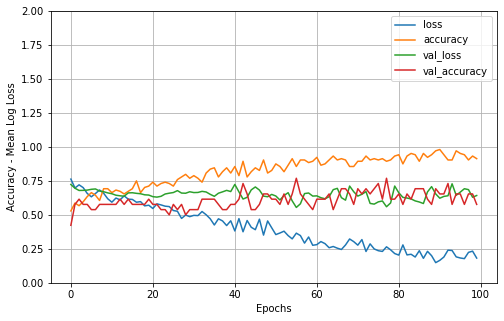

In [27]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

# categorical_accuracy es el training accuracy
# val_categorical_accuracy es el validation accuracy
# loss es el training loss
# val_loss es el validation loss

# Overfitting:
# Por un lado la Accuracy de los datos de entrenamiento aumenta con las epochs,
# mientras que la Accuracy de los datos de validación disminuye o se mantiene constante a lo largo de las epochs. 
# La Loss de los datos de validación alcanza su mínimo después de pocos epochs y luego empieza a subir, 
# mientras que la Loss de los datos de entrenamiento disminuye linealmente.

In [28]:
history.params

{'verbose': 2, 'epochs': 100, 'steps': 4}

In [29]:
results[-1:]

,loss,accuracy,val_loss,val_accuracy
99,0.181817,0.913462,0.642329,0.576923


In [30]:
print ("Accuracy for the training set: ", results.values[-1:][0][1])

Accuracy for the training set:  0.9134615659713745


In [31]:
print ("Accuracy for the development test set: ", results.values[-1:][0][3])

Accuracy for the development test set:  0.5769230723381042


#### Let's see how the model predicts using the development test set:

In [32]:
dev_predictions=model.predict(X_dev).round(2) 
dev_predictions[:20]

array([[0.44, 0.56],
       [0.84, 0.16],
       [0.78, 0.22],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.5 , 0.5 ],
       [0.02, 0.98],
       [0.01, 0.99],
       [0.01, 0.99],
       [0.04, 0.96],
       [0.  , 1.  ],
       [0.92, 0.08],
       [0.87, 0.13],
       [0.42, 0.58],
       [0.39, 0.61],
       [0.08, 0.92],
       [0.68, 0.32],
       [0.48, 0.52],
       [0.77, 0.23],
       [0.87, 0.13]], dtype=float32)

In [33]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [34]:
y_dev[:20]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [35]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(y_dev,1))
print (dev_correct_predictions[:30])

[False  True  True  True  True False  True  True  True  True  True  True
  True False False False False  True False False  True False False  True
 False  True]


In [36]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({False: 11, True: 15})

### 9. Save model

We save the model if it is better than others 

In [37]:
# Save
model.save('./Modelos/CNN_model3_ce_PARES_DIA.h5') # Change the name in each model

In [38]:
# Extract
"""
new_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')

import numpy as np

# Verify state
new_predictions = new_model.predict(X_dev)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Note that the optimizer state is also preserved:
# you can resume training where you left off.
"""

"\nnew_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')\n\nimport numpy as np\n\n# Verify state\nnew_predictions = new_model.predict(X_dev)\nnp.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)\n\n# Note that the optimizer state is also preserved:\n# you can resume training where you left off.\n"

### 10 - Final Test

#### 10.1 - Load the final test set

#### 10.2 - Evaluate the model

In [39]:

from collections import Counter
def predictWithModel(model, X_test, y_test, task1, task2, task3=""):
    model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test)
    test_rounded_predictions=np.round(test_predictions)
    indices = np.argmax(test_predictions,1)
    for row, index in zip(test_rounded_predictions, indices): row[index]=1
    print(test_rounded_predictions[:20])
    
    # ACCURACY:
    test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(y_test,1))
    print()
    print(test_correct_predictions)
    print(type(test_correct_predictions))
    final_test_prediction_results=Counter(test_correct_predictions)
    
    success = np.mean(test_rounded_predictions == y_test)*100
    
    return final_test_prediction_results, success


In [40]:

accuracy, success = predictWithModel(model, X_test, y_test, 402,404)
print(accuracy, success)

1/1 [==============================] - 0s 17ms/step - loss: 0.2850 - accuracy: 0.8462
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]

[ True  True  True  True  True  True  True  True False False  True  True
  True]
<class 'numpy.ndarray'>
Counter({True: 11, False: 2}) 84.61538461538461
